In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from collections import Counter
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, \
train_test_split, validation_curve
from xgboost.sklearn import XGBClassifier

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(15,7)}, style='whitegrid')
plt.rcParams['figure.figsize'] = (15,7)

In [2]:
DATA_PATH = 'data/'

TRAIN_FEATURES = os.path.join(DATA_PATH, 'train_new_features.csv')

In [3]:
train_df = pd.read_csv(TRAIN_FEATURES, index_col=0, encoding='utf-8')

In [4]:
train_df.head(2)

,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,deed reason earthquak may allah forgiv us,1,13,6,0.461538,0,4.384615,69,1,1,0,0.0,0.0,7,1.0,0.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la rong sask canada,1,7,0,0.000000,0,4.571429,38,1,0,0,0.1,0.4,7,1.0,0.1,0.4,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data preparation

Check for null values and fill in them.

In [5]:
if train_df.isnull().any().any():
    print('Found missing values in data')
else:
    print('No missing values in data')

Found missing values in data


In [6]:
train_isnull_count = pd.DataFrame(train_df.isnull().sum()).T
train_isnull_count

,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
train_df.fillna('', inplace = True)

In [8]:
if train_df.isnull().any().any():
    print('Found missing values in data')
else:
    print('No missing values in data')

No missing values in data


In [9]:
train = train_df['preprocessed_text']
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=13, stratify=y)

In [10]:
X_train.shape, X_test.shape

((5264,), (2256,))

## Convert a collection of tweets to a matrix of TF-IDF features

First, we will create a dictionary of all the words using TfidfVectorizer.

Secondly, we are encoding the sentences from the training set texts with the indices of incoming words. We'll use the sparse format.

Third, we will apply the same operations to the test set.

We exclude words with low and high document frequency across the corpus, as this words could be misspelled or rare words.

In [11]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range=(1, 1)) # only unigrams

X_train_tfidf = vectorizer.fit_transform(X_train)

X_test_tfidf = vectorizer.transform(X_test)

In [12]:
X_train_tfidf.shape, X_test_tfidf.shape

((5264, 1807), (2256, 1807))

## Dataset visualization

We use a singular value decomposition to reduce our dataset to two dimensions. This will allow us to see any inherent linear seperability in the data that our model could capitalize on.

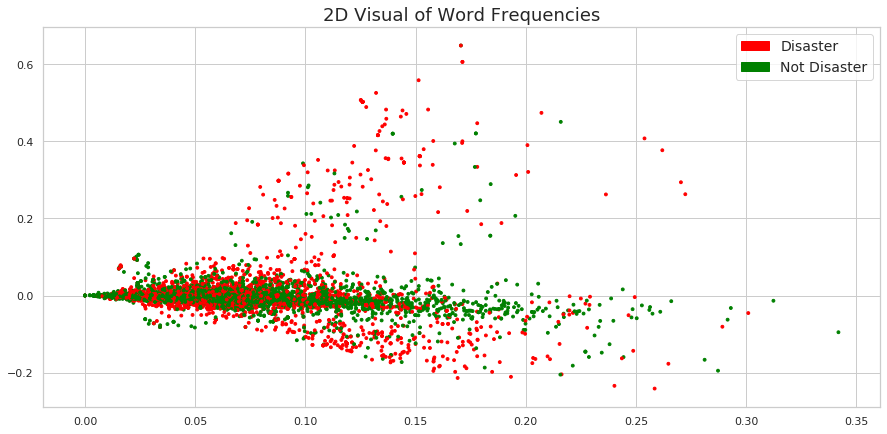

In [13]:
def plot_lsa(text, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(text)
    lsa_scores = lsa.transform(text)
    color_dict = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_dict[label] for label in labels]
    colors = ['green', 'red']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        green_patch = mpatches.Patch(color='green', label='Not Disaster')
        red_patch = mpatches.Patch(color='red', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 14})
        
plot_lsa(X_train_tfidf, y_train)
plt.title("2D Visual of Word Frequencies", size = 18)
plt.show()

### APPROACHES:
 - linear model (Logistic Regression),
 - boosting (XGBoost)

**Define evaluation procedure.**

We will use repeated cross-validation to evaluate the model, with 5-fold cross-validation.

In [14]:
kf = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)

**Define functions for reports with numbers and plots.**

```The leaderboard is based on Mean F-Score which can be implemented with Macro Average F1 Score.```

In [15]:
def plot_cv_with_err(model,
                     data_X,
                     data_y,
                     parameter_name, 
                     params,
                     cv_score,
                     **kwargs):
    
    """Plot results of cv_output_all"""
    
    val_train, val_test = validation_curve(model,
                                           data_X,
                                           data_y,
                                           param_name=parameter_name,
                                           param_range=params,
                                           cv=kf,
                                           scoring=cv_score)
    
    means_train = np.mean(val_train, axis=1)
    stds_train = np.std(val_train, axis=1)
    means_test = np.mean(val_test, axis=1)
    stds_test = np.std(val_test, axis=1)

    lines_train = plt.plot(params, means_train,
                           '-', label='CV training scores on train set', **kwargs)
    lines_test = plt.plot(params, means_test,
                          '-', label='CV validation scores on train set', **kwargs)
    
    plt.fill_between(params, means_train - stds_train, means_train + stds_train,
                     edgecolor='none', facecolor=lines_train[0].get_color(), alpha=0.2)
    plt.fill_between(params, means_test - stds_test, means_test + stds_test,
                     edgecolor='none', facecolor=lines_test[0].get_color(), alpha=0.2)

In [16]:
def cv_output_all(model,
                  data_X,
                  data_y,
                  parameter_name, 
                  params,
                  cv_score):
    
    """Same as plot_cv_with_err"""
    
    val_train, val_test = validation_curve(model,
                                           data_X,
                                           data_y,
                                           param_name=parameter_name,
                                           param_range=params,
                                           cv=kf,
                                           scoring=cv_score)
    means_train = np.mean(val_train, axis=1)
    stds_train = np.std(val_train, axis=1)
    means_test = np.mean(val_test, axis=1)
    stds_test = np.std(val_test, axis=1)
    
    print("                                    CV scores on Train set")
    print("================================================================================================")
    print("  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter")
    print("================================================================================================")
    for mean_tr, stdev_tr, mean_te, stdev_te, param \
            in zip(means_train, stds_train, means_test, stds_test, params):
        print("    {:^{width}.{prec}}  ({:^{width}.{prec}}) |   {:^{width}.{prec}}  ({:^{width}.{prec}}) | {:{align}} = {:{align}.{prec}}"
              .format(mean_tr, stdev_tr,
                      mean_te, stdev_te,
                      parameter_name, param,
                      align='<', width='14', prec=5))


## LOGISTIC REGRESSION 

**Define model.**

In [17]:
lr = LogisticRegression(solver='liblinear', penalty='l1', C=1e5,
                        class_weight='balanced', random_state=13)

In [18]:
lr.fit(X_train_tfidf, y_train)

/home/asia/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Evaluate model, establish a baseline.**

In [19]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, lr.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, lr.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.97153

f1_score (test set):  0.71267


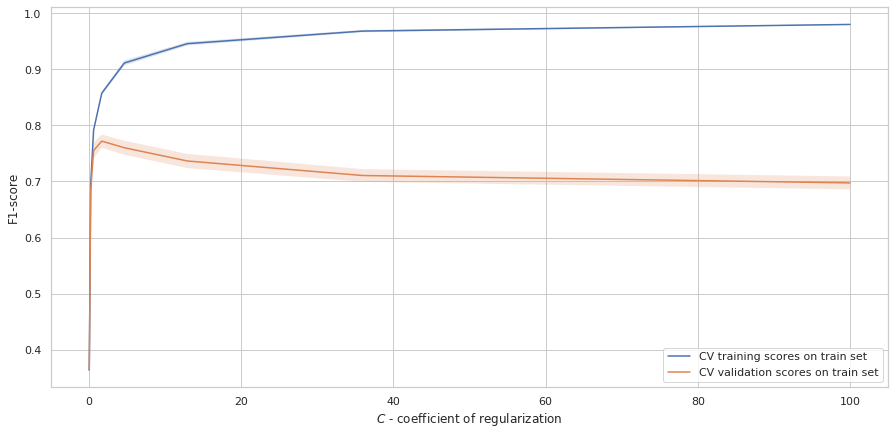

In [20]:
plot_cv_with_err(model = lr,
                 data_X = X_train_tfidf,
                 data_y = y_train,
                 parameter_name = 'C', 
                 params = np.logspace(-2, 2, 10),
                 cv_score = 'f1_macro')

plt.xlabel("$C$ - coefficient of regularization")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.grid(True)

In [21]:
lr_1 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=13)

lr_param_grid_1 = {'penalty': ['l1', 'l2'],
                   'C': np.logspace(-2, 2, 10)}

lr_clf_1 = GridSearchCV(estimator=lr_1, cv=kf, param_grid=lr_param_grid_1, scoring='f1_macro', verbose=1)

%time  lr_clf_1.fit(X_train_tfidf, y_train)

print("\nBest_params: {}, best_score: {:.5}".format(lr_clf_1.best_params_, lr_clf_1.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 5.19 s, sys: 3.98 ms, total: 5.19 s
Wall time: 5.19 s

Best_params: {'C': 0.5994842503189409, 'penalty': 'l2'}, best_score: 0.78447


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished


In [22]:
lr_2 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=13)

lr_param_grid_2 = {'penalty': ['l2'],
                   'C': np.linspace(0.001, 10, 40)}

lr_clf_2 = GridSearchCV(estimator=lr_2, cv=kf, param_grid=lr_param_grid_2, scoring='f1_macro', verbose=1)

%time  lr_clf_2.fit(X_train_tfidf, y_train)

print("\nBest_params: {}, best_score: {:.5}".format(lr_clf_2.best_params_, lr_clf_2.best_score_))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 3.28 s, sys: 3.96 ms, total: 3.29 s
Wall time: 3.28 s

Best_params: {'C': 0.7701538461538461, 'penalty': 'l2'}, best_score: 0.78487


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.3s finished


**Final model.**

In [23]:
lr_final = LogisticRegression(C=0.8, penalty='l2', solver='liblinear', class_weight='balanced', random_state=13)

%time lr_final.fit(X_train_tfidf, y_train)

CPU times: user 14 ms, sys: 7.92 ms, total: 21.9 ms
Wall time: 21 ms


LogisticRegression(C=0.8, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**Evaluate model.**

In [24]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, lr_final.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, lr_final.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.85192

f1_score (test set):  0.7918


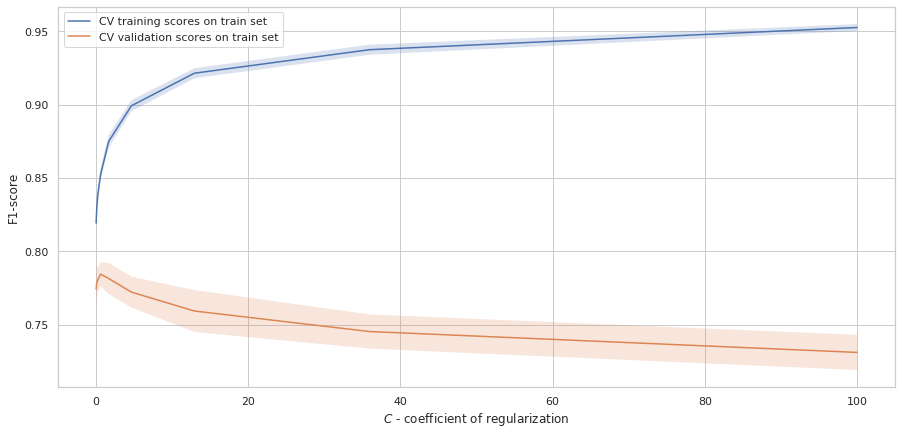

In [25]:
plot_cv_with_err(model = lr_final,
                 data_X = X_train_tfidf,
                 data_y = y_train,
                 parameter_name = 'C', 
                 params = np.logspace(-2, 2, 10),
                 cv_score = 'f1_macro')

plt.xlabel("$C$ - coefficient of regularization")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.grid(True)

The trend is quite visible.

Training and validation errors differ significantly. This can be explained by **overfitting**. When there are too many parameters or regularization is not strict enough, the algorithm can be "distracted" by the noise in the data and lose track of the overall trend.

Our model tend to be overfitted.

In [26]:
cv_output_all(model = lr_final,
              data_X = X_train_tfidf,
              data_y = y_train,
              parameter_name = 'C', 
              params = np.linspace(0.001, 5, 40),
              cv_score = 'f1_macro'
             )

                                    CV scores on Train set
  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter
       0.81222      (  0.0045836   ) |      0.76797      (   0.010147   ) | C = 0.001
       0.83159      (  0.0034191   ) |      0.77979      (   0.011282   ) | C = 0.12918
        0.839       (   0.004083   ) |      0.78099      (   0.008219   ) | C = 0.25736
       0.84476      (  0.0039076   ) |      0.78078      (  0.0087805   ) | C = 0.38554
       0.84921      (  0.0039964   ) |      0.78366      (  0.0084972   ) | C = 0.51372
       0.85325      (  0.0041069   ) |      0.78465      (  0.0078636   ) | C = 0.6419
       0.85725      (  0.0045816   ) |      0.78487      (  0.0086915   ) | C = 0.77008
       0.86044      (  0.0045669   ) |      0.78354      (  0.0091081   ) | C = 0.89826
       0.86397      (   0.005171   ) |      0.78414      (  0.0094493   ) | C = 1.0264
       0.86639      (  0.0052582   ) |      0.78427      (  0.


## XGBoost Classifier

Before any modification or tuning is made to the XGBoost algorithm for imbalanced classification, it is important to test the default XGBoost model and **establish a baseline in performance**.

**Define model.**

In [27]:
xgb = XGBClassifier(objective='binary:logistic', booster='gbtree', random_state=13)

**Fit model (optimize model loss function).**

In [28]:
xgb.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Evaluate model, establish a baseline.**

In [29]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.86301

f1_score (test set):  0.77271


**Imbalanced Classification.**

The *scale_pos_weight* can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

- #### scale_pos_weight = total_negative_examples / total_positive_examples

In [30]:
counter = Counter(y_train)
estimate = counter[0] / counter[1]
print('scale_pos_weight: %.3f' % estimate)

scale_pos_weight: 1.336


**Hyperparameter optimization.**

In [31]:
xgb_1 = XGBClassifier(scale_pos_weight=1.336, learning_rate=0.26,
                      max_depth=7, min_child_weight=1, gamma=0,
                      colsample_bytree=0.9, subsample=0.85,
                      reg_alpha=0.1, reg_lambda=0.01,
                      objective='binary:logistic', booster='gbtree', random_state=13)

xgb_1.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.26, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0.1,
              reg_lambda=0.01, scale_pos_weight=1.336, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb_1.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb_1.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.89407

f1_score (test set):  0.77927


**Early Stopping to Avoid Overfitting.**

It avoids overfitting by attempting to automatically select the inflection point where **performance on the test dataset starts to decrease** while **performance on the training dataset continues to improve** as the model starts to overfit.

In [33]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_tfidf, y_train,
                                            test_size=0.33, random_state=7)

xgb_2 = XGBClassifier(scale_pos_weight=1.336, learning_rate=0.26,
                      max_depth=7, min_child_weight=1, gamma=0,
                      colsample_bytree=0.9, subsample=0.85,
                      reg_alpha=0.1, reg_lambda=0.01,
                      objective='binary:logistic', booster='gbtree', random_state=13)

eval_set = [(X_tr, y_tr), (X_val, y_val)]

xgb_2.fit(X_tr, y_tr, eval_metric=['error', 'logloss'], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.34912	validation_0-logloss:0.66866	validation_1-error:0.35788	validation_1-logloss:0.67441
[1]	validation_0-error:0.32218	validation_0-logloss:0.65155	validation_1-error:0.33775	validation_1-logloss:0.66113
[2]	validation_0-error:0.30601	validation_0-logloss:0.63815	validation_1-error:0.31933	validation_1-logloss:0.64766
[3]	validation_0-error:0.28616	validation_0-logloss:0.62562	validation_1-error:0.29689	validation_1-logloss:0.63890
[4]	validation_0-error:0.25752	validation_0-logloss:0.61345	validation_1-error:0.28136	validation_1-logloss:0.62931
[5]	validation_0-error:0.24702	validation_0-logloss:0.60320	validation_1-error:0.27330	validation_1-logloss:0.61971
[6]	validation_0-error:0.24560	validation_0-logloss:0.59541	validation_1-error:0.27158	validation_1-logloss:0.61488
[7]	validation_0-error:0.23568	validation_0-logloss:0.58595	validation_1-error:0.27273	validation_1-logloss:0.60857
[8]	validation_0-error:0.22717	validation_0-logloss:0.57776	validation_1

[71]	validation_0-error:0.10834	validation_0-logloss:0.35907	validation_1-error:0.22382	validation_1-logloss:0.50520
[72]	validation_0-error:0.10692	validation_0-logloss:0.35714	validation_1-error:0.22324	validation_1-logloss:0.50470
[73]	validation_0-error:0.10579	validation_0-logloss:0.35562	validation_1-error:0.22152	validation_1-logloss:0.50420
[74]	validation_0-error:0.10465	validation_0-logloss:0.35394	validation_1-error:0.22209	validation_1-logloss:0.50529
[75]	validation_0-error:0.10352	validation_0-logloss:0.35208	validation_1-error:0.22209	validation_1-logloss:0.50501
[76]	validation_0-error:0.10210	validation_0-logloss:0.35063	validation_1-error:0.21922	validation_1-logloss:0.50458
[77]	validation_0-error:0.10153	validation_0-logloss:0.34891	validation_1-error:0.21979	validation_1-logloss:0.50473
[78]	validation_0-error:0.09926	validation_0-logloss:0.34666	validation_1-error:0.21979	validation_1-logloss:0.50325
[79]	validation_0-error:0.09841	validation_0-logloss:0.34510	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.26, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0.1,
              reg_lambda=0.01, scale_pos_weight=1.336, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

By default for XGBClassifier *eval_metric = 'error'*.

In [34]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb_2.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb_2.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.85994

f1_score (test set):  0.7687


**Plot performance metrics.**

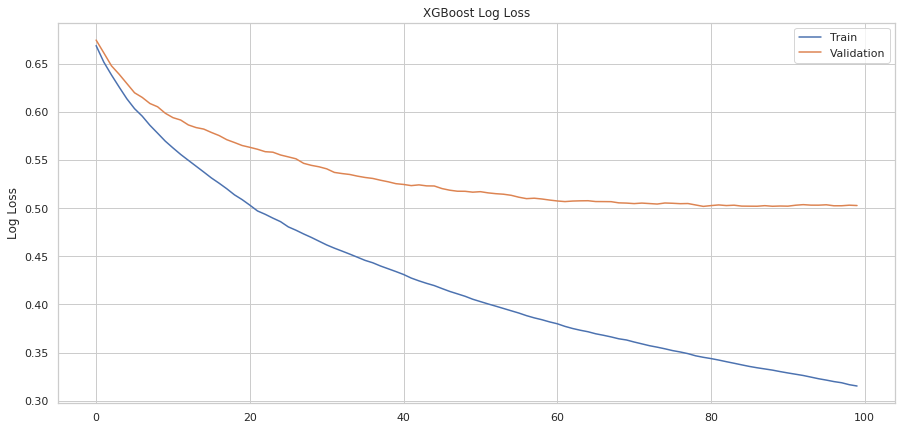

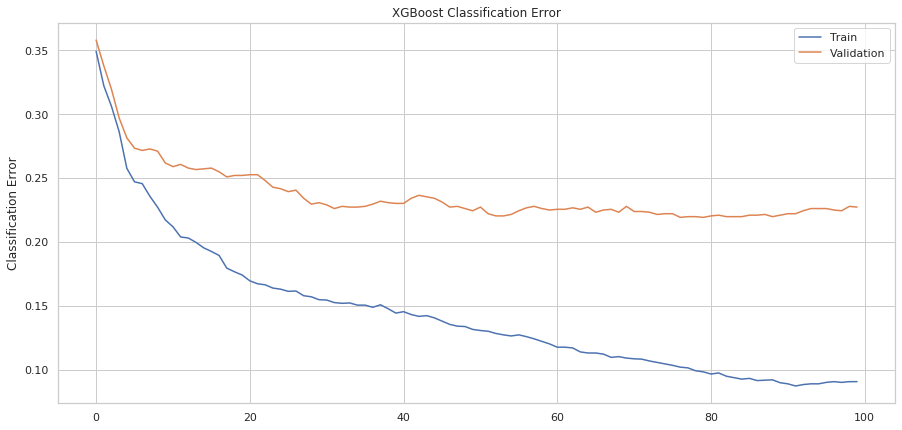

In [35]:
results = xgb_2.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

The first plot shows the logarithmic loss of the XGBoost model for each epoch on the training and test datasets.

The second plot shows the classification error of the XGBoost model for each epoch on the training and test datasets.

From reviewing the logloss plot, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 90 to epoch 100.

We see a similar story for classification error, where error appears to go back up at around epoch 80.

### Final model.

In [36]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_tfidf, y_train,
                                            test_size=0.33, random_state=13)

xgb_final = XGBClassifier(scale_pos_weight=1.336, learning_rate=0.26,
                          max_depth=7, min_child_weight=1, gamma=0,
                          colsample_bytree=0.9, subsample=0.85,
                          reg_alpha=0.1, reg_lambda=0.01,
                          objective='binary:logistic', booster='gbtree', random_state=13)

eval_set = [(X_val, y_val)]
xgb_final.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='error', eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.36364
Will train until validation_0-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.32796
[2]	validation_0-error:0.31358
[3]	validation_0-error:0.28999
[4]	validation_0-error:0.28769
[5]	validation_0-error:0.27963
[6]	validation_0-error:0.27503
[7]	validation_0-error:0.27158
[8]	validation_0-error:0.26755
[9]	validation_0-error:0.26697
[10]	validation_0-error:0.26985
[11]	validation_0-error:0.26410
[12]	validation_0-error:0.26122
[13]	validation_0-error:0.26352
[14]	validation_0-error:0.26064
[15]	validation_0-error:0.26295
[16]	validation_0-error:0.26525
[17]	validation_0-error:0.26410
[18]	validation_0-error:0.26467
[19]	validation_0-error:0.26697
[20]	validation_0-error:0.26812
[21]	validation_0-error:0.26870
[22]	validation_0-error:0.26467
[23]	validation_0-error:0.26179
[24]	validation_0-error:0.25777
[25]	validation_0-error:0.26064
[26]	validation_0-error:0.26007
[27]	validation_0-error:0.26007
[28]	validation_0-error:0.25604
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.26, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=13, reg_alpha=0.1,
              reg_lambda=0.01, scale_pos_weight=1.336, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Evaluate model.**

In [37]:
print("f1_score (train set): {:.5}".format(
            f1_score(y_train, xgb_final.predict(X_train_tfidf), average='macro')
))

print("\nf1_score (test set):  {:.5}".format(
            f1_score(y_test, xgb_final.predict(X_test_tfidf), average='macro')
))

f1_score (train set): 0.81744

f1_score (test set):  0.76263


We can see that **the model stopped training at epoch 67** (close to what we expected by our manual judgment of learning curves) and that the model with **the best loss was observed at epoch 37**.

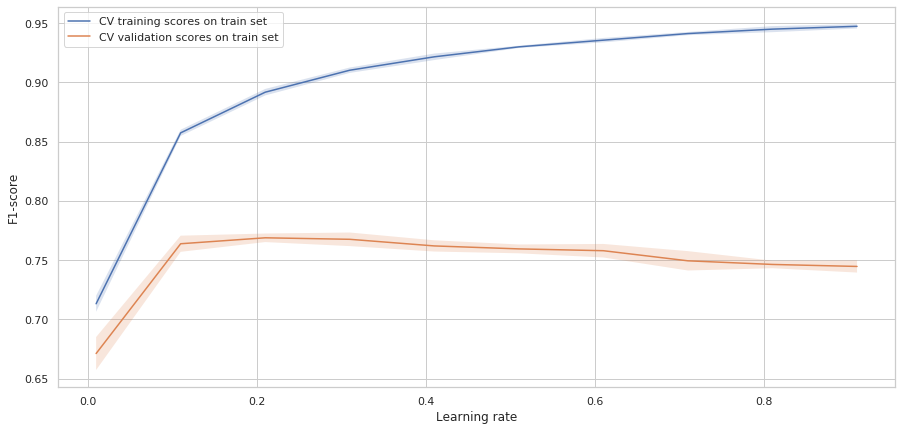

In [38]:
plot_cv_with_err(model = xgb_final,
                 data_X = X_train_tfidf,
                 data_y = y_train,
                 parameter_name = 'learning_rate',
                 params = [i/100.0 for i in range(1,101,10)],
                 cv_score = 'f1_macro')

plt.xlabel("Learning rate")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.grid(True)

In [39]:
cv_output_all(model = xgb_final,
              data_X = X_train_tfidf,
              data_y = y_train,
              parameter_name = 'learning_rate', 
              params = [i/100.0 for i in range(1,101,10)],
              cv_score = 'f1_macro'
             )

                                    CV scores on Train set
  mean_train_score (std_train_score) | mean_valid_score (std_valid_score) |      parameter
       0.71316      (  0.0067821   ) |      0.67113      (   0.013909   ) | learning_rate = 0.01
       0.85742      (  0.0026365   ) |       0.7638      (  0.0068143   ) | learning_rate = 0.11
       0.89174      (  0.0027421   ) |      0.76883      (  0.0036088   ) | learning_rate = 0.21
       0.91029      (   0.002269   ) |      0.76756      (   0.005736   ) | learning_rate = 0.31
       0.92161      (  0.0027507   ) |      0.76196      (  0.0047396   ) | learning_rate = 0.41
       0.93001      (  0.00097014  ) |      0.75946      (  0.0037264   ) | learning_rate = 0.51
       0.93566      (  0.0018747   ) |      0.75793      (  0.0057136   ) | learning_rate = 0.61
       0.94123      (  0.0013463   ) |      0.74939      (  0.0081738   ) | learning_rate = 0.71
       0.94497      (  0.0025587   ) |      0.74633      (  0.0031948   ) 

## Results

In [40]:
def get_scores(estimator, X, y, name):
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    columns = ['accuracy', 'precision', 'recall', 'F1-macro', 'AUC-ROC']
    results = pd.DataFrame([accuracy, precision, recall, f1, roc_auc], index=columns, columns=[name]).T

    return results

In [41]:
results_lr = get_scores(lr_final, X = X_test_tfidf, y = y_test, name = 'LR')
results_xgb = get_scores(xgb_final, X = X_test_tfidf, y = y_test, name = 'XGB')

In [42]:
results_lr.append(results_xgb)

,accuracy,precision,recall,F1-macro,AUC-ROC
LR,0.795656,0.756098,0.770984,0.791801,0.867187
XGB,0.772163,0.768772,0.668394,0.762635,0.817116


## Mispredicted tweets with Logistic Regression

**Predicted Neg/Actual Pos**

In [43]:
def find_fn(ypred, ytrue):
    y_fn  = X_test[(ypred==0)&(ypred!=ytrue)]
    return y_fn

y_pred_logr = lr_final.predict(X_test_tfidf)
fn = find_fn(y_pred_logr, y_test)
print('Number of False Negatives (Predicted Not Disaster/Actual Disaster): ', fn.shape, '\n') ;
train_df.loc[fn.index,:]

Number of False Negatives (Predicted Not Disaster/Actual Disaster):  (221,) 



,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
1817,This guy bought my car on Tuesday police knocked my door yday cos he crashed n ran &amp; 2day he text me asking not to send the log book????????,1,this guy bought my car on tuesday police knocked my door yday cos he crashed n ran day he text me asking not to send the log book,guy bought car tuesday polic knock door yday cos crash n ran day text ask send log book,1,29,10,0.344828,0,4.000000,144,10,0,0,0.000000,0.000000,18,1.000000,0.000000,0.000000,2.0,7.0,2.0,0.0,0.0,1.0,0.0,1.0,3.0,3.0,0.0,0.0,4.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5719,@aelinrhee a group of mascara smeared girls rioting will be horrific I think,1,a group of mascara smeared girls rioting will be horrific i think,group mascara smear girl riot horrif think,1,13,5,0.384615,0,4.923077,76,1,0,1,-1.000000,1.000000,7,1.000000,0.000000,0.000000,1.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6820,@lucysforsale funny cause my dumb ass was the young one to get n trouble the most lol,1,funny cause my dumb ass was the young one to get n trouble the most lol,funni caus dumb ass young one get n troubl lol,1,17,6,0.352941,0,4.058824,85,1,0,1,0.179167,0.550000,10,1.000000,0.175000,0.533333,2.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1606,Why did I come to work today.. Literally wanna collapse of exhaustion,1,why did i come to work today literally want to collapse of exhaustion,come work today liter want collaps exhaust,1,12,5,0.416667,0,4.833333,69,2,0,0,0.000000,0.000000,7,1.000000,0.000000,0.000000,0.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4816,@KabarMesir @badr58 \nNever dies a big Crime like RABAA MASSACRE as long the revolution is being observed.\n#rememberRABAA,1,never dies a big crime like rabaa massacre as long the revolution is being observed rememberrabaa,never die big crime like rabaa massacr long revolut observ rememberrabaa,3,18,5,0.277778,0,5.666667,120,4,1,2,-0.025000,0.250000,11,1.000000,-0.025000,0.250000,2.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2876,I can't drown my demons they know how to swim,1,i cannot drown my demons they know how to swim,drown demon know swim,1,10,5,0.500000,0,3.600000,45,1,0,0,0.000000,0.000000,4,1.000000,0.000000,0.000000,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6527,Really cannot condemn an entire group based on the actions of a few.. A heart-warming unity against terrorism.. http://t.co/HHPvPaEL4n,1,really cannot condemn an entire group based on the actions of a few a heart warming unity against terrorism,realli condemn entir group base action heart warm uniti terror,1,19,7,0.368421,1,6.105263,134,10,0,0,0.000000,0.308333,10,1.000000,-0.033333,0.566667,4.0,4.0,0.0,1.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354,One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1392,1,one direction is my pick for fan army directioners x,one direct pick fan armi direction x,1,12,3,0.250000,2,7.666667,103,11,1,0,0.000000,0.000000,7,1.000000,0.100000,0.400000,0.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

**Predicted Pos/ Actual Neg**

In [44]:
def find_fp(ypred, ytrue):
    y_fp  = X_test[(ypred==1)&(ypred!=ytrue)]
    return y_fp

fp = find_fp(y_pred_logr, y_test)
print('Number of False Positives (Predicted Disaster/Actual Not Disaster)): ', fp.shape, '\n') ;
train_df.loc[fp.index,:]

Number of False Positives (Predicted Disaster/Actual Not Disaster)):  (240,) 



,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
3498,It's lights out again with stage-two load shedding: Stage-two load shedding will be in force between 5pm and 10pm. http://t.co/vxVfAEEY0q,0,it is lights out again with stage two load shedding stage two load shedding will be in force between pm and pm,light stage two load shed stage two load shed forc pm pm,1,20,9,0.450000,1,5.900000,137,10,0,0,0.000000e+00,0.000000,7,0.583333,0.400000,0.700000,0.0,7.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1052,beforeitsnews : Global Derivatives: $1.5 Quadrillion Time Bomb http://t.co/GhmmUj7GbE (vÛ_ http://t.co/u9LvvLzhYe) http://t.co/LyJ57pq3yX,0,beforeitsnews global derivatives quadrillion time bomb v,beforeitsnew global deriv quadrillion time bomb v,1,12,0,0.000000,3,10.583333,138,22,0,0,0.000000e+00,0.000000,7,1.000000,0.000000,0.000000,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2782,@cncpts @SOLELINKS what a disaster - can't say I'm surprised,0,what a disaster cannot say i am surprised,disast say surpris,1,10,2,0.200000,0,5.100000,60,5,0,2,1.000000e-01,0.900000,3,1.000000,0.000000,0.000000,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7355,11 puncture wounds,0,puncture wounds,punctur wound,1,3,0,0.000000,0,5.333333,18,0,0,0,0.000000e+00,0.000000,2,1.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5556,Captain Abbott must go down with LNP boat #refugees #christianvalues https://t.co/Kp5dpOaF58,0,captain abbott must go down with lnp boat refugees christianvalues,captain abbott must go lnp boat refuge christianvalu,1,11,2,0.181818,1,7.454545,92,7,2,0,-1.555556e-01,0.288889,8,1.000000,0.000000,0.000000,0.0,3.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1624,+ DID YOU SAY TO HIM!!?!?!?!' and phil actually collapsed on the gravel sobbing endlessly with a crowd watching him confused angry mad+,0,did you say to him and phil actually collapsed on the gravel sobbing endlessly with a crowd watching him confused angry mad,say phil actual collaps gravel sob endless crowd watch confus angri mad,1,23,9,0.391304,0,4.913043,135,11,0,0,-3.300000e-01,0.710000,12,1.000000,-0.250000,0.616667,2.0,3.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,3.0,0.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7308,The whole food stamp gov. assistance program needs to be retooled for wounded veterans retirees and handicapped only. #NoMoreHandouts,0,the whole food stamp gov assistance program needs to be retooled for wounded veterans retirees and handicapped only nomorehandouts,whole food stamp gov assist program need retool wound veteran retire handicap nomorehandout,1,19,5,0.263158,0,6.052632,134,3,1,0,1.000000e-01,0.700000,13,1.000000,0.100000,0.200000,1.0,5.0,0.0,4.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5962,ENGLAND EAST COAST. Dogger Bank Westward. 1. Seismic survey in progress by M/V Western Regent towing a 8400 metre long cable within areaÛ_,0,england east coast dogger bank westward seismic survey in progress by m v western regent towing a metre long cable within area,england east coast dogger bank westward seismic survey progress v western regent tow metr long cabl within area,1,2

## CONCLUSIONS

1. Logistic Regression and XGBoost machine learning models with tuned hyperparameters were applied to the TF-IDF matrix obtained from the preprocessed texts.
2. Our data is a sparse matrix thats why Logistic Regression works better then Boosting algorithm.